In [39]:
#Import necessary tools
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
import re
import nltk
print("Setup Complete!")

Setup Complete!


## Import Data

In [8]:
df = pd.read_csv('wine.csv', index_col = 0)

In [9]:
#Look at the head of the data to get a feel for what information is contained and how it's laid out
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Pre-processing

In [10]:
#Check the shape of the data to get a feel for how large it is.
df.shape

(129971, 13)

With relatively few columns there really isn't much to drop. We'll keep all columns for now just in case they end up being useful to our analysis.

Now let's take a little bit closer look at some of the descriptions to get a feel for what kind of verbiage we're working with. Ultimately, the plan is to try to use these descriptions to try and predict a wine's varietal and country of origin.

In [11]:
df.description[0]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."

In [12]:
df.description[1]

"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016."

Next, let's look at what all NA data we have

In [13]:
df.isna().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

That's quite a bit of NA's but since our analysis is primarily concerned with price, description, and points it looks like we can probably do by just dropping observations that have NaN price. This will keep us in the range of ~1.2m observations vs. ~292k if we dropped all NA values.

In [14]:
#Drop NaN price obs
df = df.dropna(subset = ['price'])

Next, let's check for dupliates

In [15]:
df.duplicated().value_counts()

False    111593
True       9382
dtype: int64

Looks like we don't have any duplicates! Now let's make sure that points and price are both numeric types

In [16]:
df.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

Next, let's bin wines by price. We'll preserve the original points column in case we want to do some regression or use a model that works well with numerical values but just add on a column with the following point ranges, ratings categories were retrieved from Winefolly

 50-59: undrinkable
 60-69: flawed
 70-79: average
 80-84: above average
 85-90: good
 90-94: superior
 95-100: benchmark


In [17]:
def bin_points(row):
    if row['points'] < 60:
        return "undrinkable"
    if row['points'] < 70 and row['points'] >= 60:
        return "flawed"
    if row['points'] < 80 and row['points'] >= 70:
        return 'average'
    if row['points'] < 85 and row['points'] >= 80:
        return 'above average'
    if row['points'] < 90 and row['points'] >= 85:
        return 'good'
    if row['points'] < 95 and row['points'] >= 90:
        return 'superior'
    if row['points'] >= 95:
        return 'benchmark'
      

In [18]:
#Call our categorization function on each row of the data frame
df['points_cat'] = df.apply(lambda row: bin_points(row), axis = 1)

In [19]:
#Check to make sure our new binned column is present
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,points_cat
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,good
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,good
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,good
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,good
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,good


Now that we know it's there, let's compare the value counts of the category and summary statistics of the original points values

In [20]:
df['points_cat'].value_counts()

good             63752
superior         43180
above average    11832
benchmark         2211
Name: points_cat, dtype: int64

In [21]:
df['points'].describe()

count    120975.000000
mean         88.421881
std           3.044508
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

It looks like there are no errors with mins or maxes and things generally line up so it seems that our function worked as expected.

Since we know that one of our numerical variables doesn't have any outliers, it's time to check the other. Let's take a look at price

In [22]:
z = np.abs(stats.zscore(df['price']))

In [23]:
outliers = np.where(z>3)

In [24]:
print(outliers)

(array([   268,    319,    320, ..., 120331, 120685, 120686]),)


It looks like we have a number outliers. Since we're not planning to use price at the moment we'll leave them be and clean them up in the event that we decide to use it in the future.

# Exploratory analysis and visualization

Time to start looking through our data and check whether there's anything additional that needs to be cleaned up or might be useful to know in our modeling

## Points

In [25]:
#Summary statistics for points
df['points'].describe()

count    120975.000000
mean         88.421881
std           3.044508
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [26]:
df['points'].median()

88.0

In [27]:
df['points'].mode()

0    88
dtype: int64

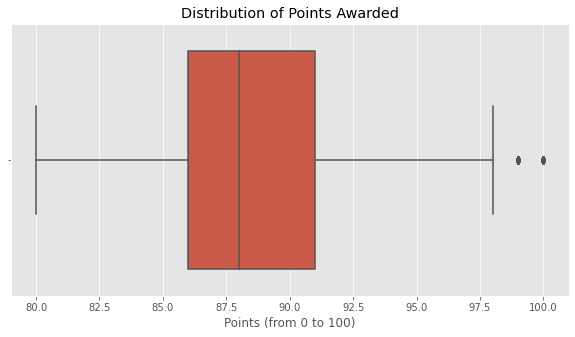

In [28]:
#Visualize the distribution of points
plt.figure(figsize = (10,5))
plt.style.use('ggplot')

ax = sns.boxplot(x = 'points', data = df)
ax.set(title = 'Distribution of Points Awarded', xlabel = 'Points (from 0 to 100)' )
plt.savefig('Points_distribution.png', bbox_inches = 'tight')


## Geographic Provenance

Let's start off by looking at country and then we'll look at more specific regions

In [29]:
df['country'].value_counts()

US                        54265
France                    17776
Italy                     16914
Spain                      6573
Portugal                   4875
Chile                      4416
Argentina                  3756
Austria                    2799
Australia                  2294
Germany                    2120
New Zealand                1378
South Africa               1293
Israel                      489
Greece                      461
Canada                      254
Hungary                     145
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Georgia                      84
Slovenia                     80
Croatia                      71
Mexico                       70
England                      69
Moldova                      59
Brazil                       47
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14
Macedoni

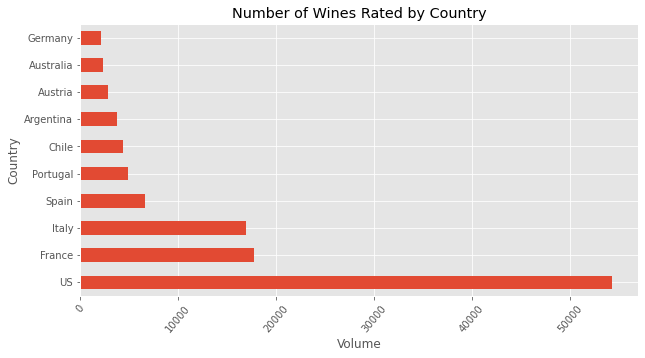

In [30]:
#That's a lot to take in, let's start by visualizing the top ten countries
plt.figure(figsize = (10,5))
plt.xticks(rotation = 50)
plt.style.use('ggplot')

df.groupby('country').size().nlargest(10).plot(kind = 'barh').set(title = 'Number of Wines Rated by Country', xlabel = 'Volume', ylabel = 'Country')
plt.savefig('country1.png', bbox_inches = 'tight')

In [31]:
df['province'].value_counts().describe()

count      422.000000
mean       286.530806
std       1892.010074
min          1.000000
25%          3.000000
50%         11.500000
75%         52.500000
max      36104.000000
Name: province, dtype: float64

Looks like there are quite a few... let's look at the top 25

In [32]:
print(df.groupby('province').size().nlargest(10))

province
California          36104
Washington           8583
Oregon               5359
Tuscany              5128
Bordeaux             4002
Northern Spain       3797
Mendoza Province     3226
Burgundy             3106
Piedmont             3089
New York             2676
dtype: int64


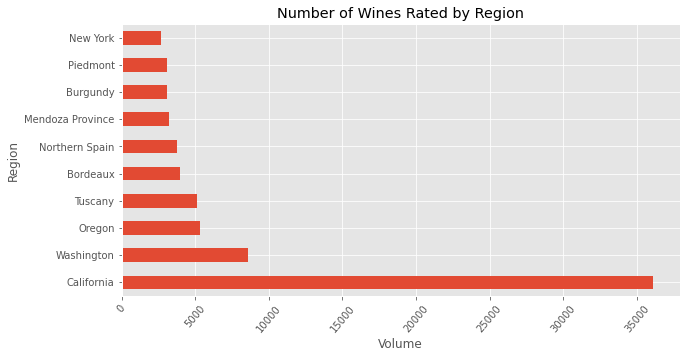

In [33]:
plt.figure(figsize = (10,5))
plt.xticks(rotation = 50)
plt.style.use('ggplot')

df.groupby('province').size().nlargest(10).plot(kind = 'barh').set(title = 'Number of Wines Rated by Region', xlabel = 'Volume', ylabel = 'Region')
plt.savefig('region1.png', bbox_inches = 'tight')

## Grape varietal


In [34]:
#Get an overview of the different varietals that were related
df['variety'].value_counts()

Pinot Noir                  12787
Chardonnay                  11080
Cabernet Sauvignon           9386
Red Blend                    8476
Bordeaux-style Red Blend     5340
                            ...  
Otskhanuri Sapere               1
Pinot Blanc-Viognier            1
Mavroudi                        1
Asprinio                        1
Trajadura                       1
Name: variety, Length: 697, dtype: int64

In [35]:
#It looks like there are quite a few- let's see how many there are in total
df['variety'].value_counts().size

697

In [36]:
#That is a lot of different varietals- let's look at the top 25
df['variety'].value_counts().nlargest(25)

Pinot Noir                  12787
Chardonnay                  11080
Cabernet Sauvignon           9386
Red Blend                    8476
Bordeaux-style Red Blend     5340
Riesling                     4972
Sauvignon Blanc              4783
Syrah                        4086
Rosé                         3262
Merlot                       3062
Zinfandel                    2708
Malbec                       2593
Sangiovese                   2377
Nebbiolo                     2331
Portuguese Red               2196
White Blend                  2172
Sparkling Blend              2027
Tempranillo                  1789
Rhône-style Red Blend        1405
Pinot Gris                   1391
Cabernet Franc               1305
Champagne Blend              1211
Grüner Veltliner             1145
Pinot Grigio                 1002
Portuguese White              986
Name: variety, dtype: int64

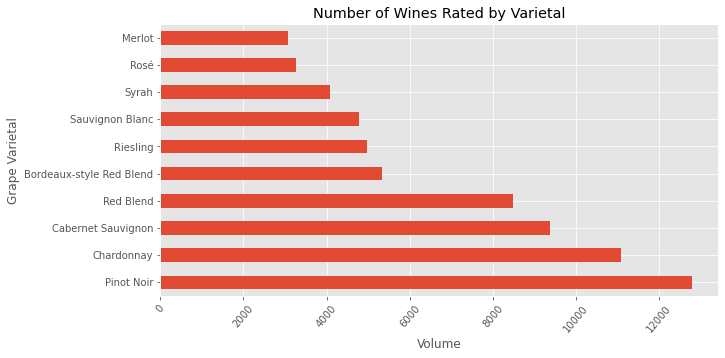

In [37]:
plt.figure(figsize = (10,5))
plt.xticks(rotation = 50)
plt.style.use('ggplot')

df.groupby('variety').size().nlargest(10).plot(kind = 'barh').set(title = 'Number of Wines Rated by Varietal', xlabel = 'Volume', ylabel = 'Grape Varietal')
plt.savefig('varietal1.png', bbox_inches = 'tight')

## Descriptive Language

Since the predictor variable is going to be the use of words in determining points, let's take a look at the frequency of different words in tasters' description

In [56]:
#Done with the assistance of data camp's tutorial on creating wordclouds
text = " ".join(review for review in df.description)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 29668538 words in the combination of all review.


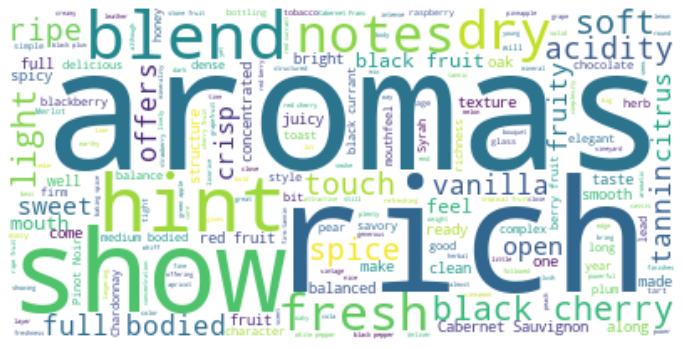

In [68]:
# Create stopword list:
plt.figure(figsize = (12, 9))
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "finish", "note", 'nose', 'give', 'offer', 'aroma', 'palate',  "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('descripto.png', bbox_inches = 'tight')

## Modeling

In [70]:
#Load in the tools that we'll need to our modeling
from sklearn.model_selection import train_test_split
import random
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [71]:
#Create training and testing split at 70/30
train, test = train_test_split(df, test_size =0.3, random_state = 1888)

In [73]:
#Check the data set to verify that no records are missing
print('DF shape:', df.shape)
print('Train shape: ',train.shape)
print('Test shape: ', test.shape)
if()

DF shape: (120975, 14)
Train shape:  (84682, 14)
Test shape:  (36293, 14)


## Model Evaluation